In [1]:
import os
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image
import torch
import tqdm
import platform
import shutil
import json
import timm
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
import yaml

# https://github.com/facebookresearch/deit/blob/7e160fe43f0252d17191b71cbb5826254114ea5b/datasets.py#L108
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Michelle
data_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/"
model_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/models/"
if platform.node() == 'navi': # Daniel
    data_prefix = "/home/argon/Stuff/CSE244A_project/"
    model_prefix = "/home/argon/Stuff/CSE244A_project/models/"

In [3]:
categories = pd.read_csv(os.path.join(data_prefix, 'categories.csv'))
train_labels = pd.read_csv(os.path.join(data_prefix, 'train_labeled.csv'))

In [4]:
def save_config(conf):
    with open(conf["model_name"] + ".yaml", 'w') as f:
        yaml.dump(conf, f)

def load_config(conf_name):
    with open(conf_name + ".yaml", 'r') as f:
        return yaml.safe_load(f)

In [5]:
# Someday this should probably be some yaml files... - Daniel

#TODO: Add batch size to this
#TODO: Add model type (e.g. facebookresearch/deit:main)

# training_config = {
#     "model_name":  "michelle_diet__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4",
#     "optimizer_type": "AdamW",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0001,
#     "scheduler_type": "ReduceLROnPlateau",
#     "scheduler_params": {"factor": 0.1,
#                          "patience": 0,
#                          "threshold": 0.0},
#     "unfreeze_layers": ['blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
# }
# save_config(training_config)
# training_config = load_config("michelle_diet__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4")

# training_config = load_config("michelle_diet_imagenetmean__freeze11__plateaulr_0.1_0_0.0__AdamW_wdecay_1en4")
# training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze11__explr_1en4_0.8__AdamW_wdecay_1en4")

# training_config = {
#     "model_name":  "michelle_diet_imagenetmean_augmentD__freeze10__explr_1en4_0.8__AdamW_wdecay_1en4",
#     "optimizer_type": "AdamW",
#     "optimizer_lr": 0.0001,
#     "optimizer_wd": 0.0001,
#     "augment_mode": "augmentD",
#     "scheduler_type": "ExponentialLR",
#     "scheduler_params": {"gamma": 0.8,},
#     "unfreeze_layers": ['blocks.10.norm1.weight', 'blocks.10.norm1.bias', 'blocks.10.attn.qkv.weight', 'blocks.10.attn.qkv.bias', 'blocks.10.attn.proj.weight', 'blocks.10.attn.proj.bias', 'blocks.10.norm2.weight', 'blocks.10.norm2.bias', 'blocks.10.mlp.fc1.weight', 'blocks.10.mlp.fc1.bias', 'blocks.10.mlp.fc2.weight', 'blocks.10.mlp.fc2.bias', 'blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
# }
# save_config(training_config)
# training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze10__explr_1en4_0.8__AdamW_wdecay_1en4")

training_config = {
    "model_name":  "michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4",
    "optimizer_type": "AdamW",
    "optimizer_lr": 0.0001,
    "optimizer_wd": 0.0001,
    "kfold": 5,
    "augment_mode": "augmentD",
    "scheduler_type": "ExponentialLR",
    "scheduler_params": {"gamma": 0.8,},
    "unfreeze_layers": ['blocks.10.norm1.weight', 'blocks.10.norm1.bias', 'blocks.10.attn.qkv.weight', 'blocks.10.attn.qkv.bias', 'blocks.10.attn.proj.weight', 'blocks.10.attn.proj.bias', 'blocks.10.norm2.weight', 'blocks.10.norm2.bias', 'blocks.10.mlp.fc1.weight', 'blocks.10.mlp.fc1.bias', 'blocks.10.mlp.fc2.weight', 'blocks.10.mlp.fc2.bias', 'blocks.11.norm1.weight', 'blocks.11.norm1.bias', 'blocks.11.attn.qkv.weight', 'blocks.11.attn.qkv.bias', 'blocks.11.attn.proj.weight', 'blocks.11.attn.proj.bias', 'blocks.11.norm2.weight', 'blocks.11.norm2.bias', 'blocks.11.mlp.fc1.weight', 'blocks.11.mlp.fc1.bias', 'blocks.11.mlp.fc2.weight', 'blocks.11.mlp.fc2.bias', 'norm.weight', 'norm.bias', 'head.weight', 'head.bias']
}
save_config(training_config)
training_config = load_config("michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4")

training_config

{'augment_mode': 'augmentD',
 'kfold': 5,
 'model_name': 'michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4',
 'optimizer_lr': 0.0001,
 'optimizer_type': 'AdamW',
 'optimizer_wd': 0.0001,
 'scheduler_params': {'gamma': 0.8},
 'scheduler_type': 'ExponentialLR',
 'unfreeze_layers': ['blocks.10.norm1.weight',
  'blocks.10.norm1.bias',
  'blocks.10.attn.qkv.weight',
  'blocks.10.attn.qkv.bias',
  'blocks.10.attn.proj.weight',
  'blocks.10.attn.proj.bias',
  'blocks.10.norm2.weight',
  'blocks.10.norm2.bias',
  'blocks.10.mlp.fc1.weight',
  'blocks.10.mlp.fc1.bias',
  'blocks.10.mlp.fc2.weight',
  'blocks.10.mlp.fc2.bias',
  'blocks.11.norm1.weight',
  'blocks.11.norm1.bias',
  'blocks.11.attn.qkv.weight',
  'blocks.11.attn.qkv.bias',
  'blocks.11.attn.proj.weight',
  'blocks.11.attn.proj.bias',
  'blocks.11.norm2.weight',
  'blocks.11.norm2.bias',
  'blocks.11.mlp.fc1.weight',
  'blocks.11.mlp.fc1.bias',
  'blocks.11.mlp.fc2.weight',
  'blocks.11.mlp.

In [6]:
def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler=None, select_layers=None):
    model_dict = model.state_dict()

    if select_layers is not None:
        # Picked this slightly convoluted method because state_dict is an OrderedDict and
        # I'm unsure what exactly that's preserving.
        possible_keys = list(model_dict.keys())
        for k in possible_keys:
            if not k in select_layers:
                model_dict.pop(k)

    checkpoint_dict = {
        "epoch": epoch,
        "model_dict": model_dict,
        "optimizer_dict": optimizer.state_dict(),
    }
    
    # Consistently name the scheduler key as "scheduler_dict"
    if scheduler:
        checkpoint_dict["scheduler_dict"] = scheduler.state_dict()

    torch.save(checkpoint_dict, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None, select_layers=None, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model_dict = checkpoint["model_dict"]
    if select_layers is None:
        model.load_state_dict(model_dict)
    else:
        missing_keys, unexpected_keys = model.load_state_dict(model_dict, strict=False)
        assert len(unexpected_keys) == 0
        assert len(missing_keys) == len(model.state_dict()) - len(select_layers)

    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_dict"])
    
    # Consistently access the scheduler as "scheduler_dict"
    if scheduler and "scheduler_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_dict"])
        
    return checkpoint["epoch"]

class TrainingHistory:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def save(self, history_path):
        with open(history_path, "w", encoding="utf-8") as f:
            json.dump({
                "train_loss": self.train_loss,
                "val_loss": self.val_loss,
                "train_acc": self.train_acc,
                "val_acc": self.val_acc,
            }, f)

    def load(self, history_path):
        with open(history_path, "r", encoding="utf-8") as f:
            hist = json.load(f)
        self.train_loss = hist["train_loss"]
        self.val_loss = hist["val_loss"]
        self.train_acc = hist["train_acc"]
        self.val_acc = hist["val_acc"]

    def append(self, train_loss, val_loss, train_acc, val_acc):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)

    def is_best(self):
        """Return true if the last epoch added is the best seen so far"""
        return all([self.val_loss[-1] < i for i in self.val_loss[:-1]])

In [7]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, label_csv=None, return_filenames=False, transform=None):
        self.label_values = None
        self.return_filenames = return_filenames
        if label_csv is not None:
            csv_data = pd.read_csv(label_csv)
            self.filenames = csv_data["image"].tolist()
            self.label_values = csv_data["id"].tolist()
        else:
            self.filenames = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        idx = int(idx)
        img_name = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        result = [image]

        if self.label_values is not None:
            result.append(self.label_values[idx])

        if self.return_filenames:
            result.append(self.filenames[idx])

        return result


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Adjust mean and std as needed
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [9]:
if not "augment_mode" in training_config:
    augmented_transform = transform
else:
    if training_config["augment_mode"] == "augment":
        # Data augmentation https://www.kaggle.com/code/pdochannel/vision-transformers-in-pytorch-deit/notebook
        augmented_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
                    transforms.RandomErasing(p=0.2, value='random')
                ])
    elif training_config["augment_mode"] == "augmentD":
        # Less augmented
        augmented_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
                ])
    else:
        raise RuntimeError("Unknown augmentation")
    augmented_transform

In [10]:
# Initialize datasets
train_dataset = ImageDataset(os.path.join(data_prefix,'train/labeled'), label_csv=os.path.join(data_prefix,'train_labeled.csv'), transform=augmented_transform)
val_dataset = ImageDataset(os.path.join(data_prefix,'train/labeled'), label_csv=os.path.join(data_prefix,'train_labeled.csv'), transform=transform)
# unlabeled_dataset = ImageDataset(os.path.join(data_prefix,'train/unlabeled'), transform=augmented_transform)

In [11]:
# Calculate folds
assert train_dataset.filenames == val_dataset.filenames

class_group_idx = {}
for i,label in enumerate(train_dataset.label_values):
    if not label in class_group_idx:
        class_group_idx[label] = []
    class_group_idx[label].append(i)

if "kfold" in training_config:
    split_num_fold = training_config["kfold"]
else:
    # If not doing kfold we want a 10% validation split
    split_num_fold = 10
split_group_idx = {}
split_ratios = torch.ones((split_num_fold,), dtype=torch.float) / split_num_fold
generator2 = torch.Generator().manual_seed(12341234)
for i in sorted(class_group_idx.keys()):
    split_group = torch.utils.data.random_split(class_group_idx[i], split_ratios, generator=generator2)
    split_group_idx[i] = split_group
    print(i, [len(j) for j in split_group])
split_ratios

0 [68, 68, 68, 67, 67]
1 [49, 49, 49, 49, 48]
2 [82, 82, 82, 82, 81]
3 [7, 7, 6, 6, 6]
4 [96, 96, 96, 96, 96]
5 [20, 20, 19, 19, 19]
6 [152, 152, 152, 152, 151]
7 [72, 72, 71, 71, 71]
8 [46, 46, 46, 46, 45]
9 [76, 76, 76, 75, 75]
10 [49, 49, 49, 48, 48]
11 [46, 46, 45, 45, 45]
12 [83, 83, 82, 82, 82]
13 [47, 47, 47, 47, 47]
14 [80, 80, 80, 79, 79]
15 [10, 10, 9, 9, 9]
16 [14, 14, 14, 13, 13]
17 [10, 9, 9, 9, 9]
18 [9, 9, 8, 8, 8]
19 [10, 10, 9, 9, 9]
20 [7, 7, 7, 7, 6]
21 [7, 7, 6, 6, 6]
22 [8, 7, 7, 7, 7]
23 [9, 9, 9, 9, 9]
24 [7, 7, 7, 7, 7]
25 [13, 13, 12, 12, 12]
26 [10, 10, 10, 9, 9]
27 [6, 6, 6, 6, 6]
28 [6, 6, 6, 6, 6]
29 [7, 7, 7, 7, 6]
30 [7, 7, 7, 7, 7]
31 [9, 8, 8, 8, 8]
32 [10, 10, 10, 10, 9]
33 [8, 7, 7, 7, 7]
34 [8, 8, 8, 7, 7]
35 [8, 8, 7, 7, 7]
36 [8, 8, 8, 8, 8]
37 [6, 6, 6, 5, 5]
38 [11, 11, 10, 10, 10]
39 [8, 8, 7, 7, 7]
40 [8, 7, 7, 7, 7]
41 [10, 10, 10, 10, 10]
42 [10, 10, 10, 10, 10]
43 [8, 8, 7, 7, 7]
44 [8, 7, 7, 7, 7]
45 [12, 12, 12, 11, 11]
46 [7, 7, 7, 7, 7]


tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [12]:
def make_fold(split_groups, fold_idx):
    assert fold_idx < len(next(iter(split_groups.values())))
    result_val = []
    result_train = []
    for i in sorted(split_groups.keys()):
        for j in range(len(split_groups[i])):
            if j == fold_idx:
                result_val.extend(split_groups[i][j])
            else:
                result_train.extend(split_groups[i][j])
    return result_train, result_val


In [13]:
batch_size = 16
if "batch_size" in training_config:
    batch_size = training_config["batch_size"]

# TODO: Use multiple folds
train_idx, val_idx = make_fold(split_group_idx, 0)
print("Train:", len(train_idx), "Val:", len(val_idx), "Ratio:", len(val_idx)/(len(val_idx)+len(train_idx)))

train =  torch.utils.data.Subset(train_dataset, train_idx)
val = torch.utils.data.Subset(val_dataset, val_idx)

labeled_train_data = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
labeled_val_data = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)

Train: 7826 Val: 2028 Ratio: 0.20580474934036938


In [14]:
# # Ensure dataset contents & ordering match
# all([train_dataset[i][1] == val_dataset[i][1] for i in range(len(train_dataset))])

# # Ensure train/val is well split along class lines
# train_classes = [i[1] for i in train]
# val_classes = [i[1] for i in val]

# print(torch.unique(torch.as_tensor(train_classes),return_counts=True)[1])
# print(torch.unique(torch.as_tensor(val_classes),return_counts=True)[1])

# print(torch.unique(torch.as_tensor(train_classes))) == print(torch.unique(torch.as_tensor(val_classes)))

Labeled images:


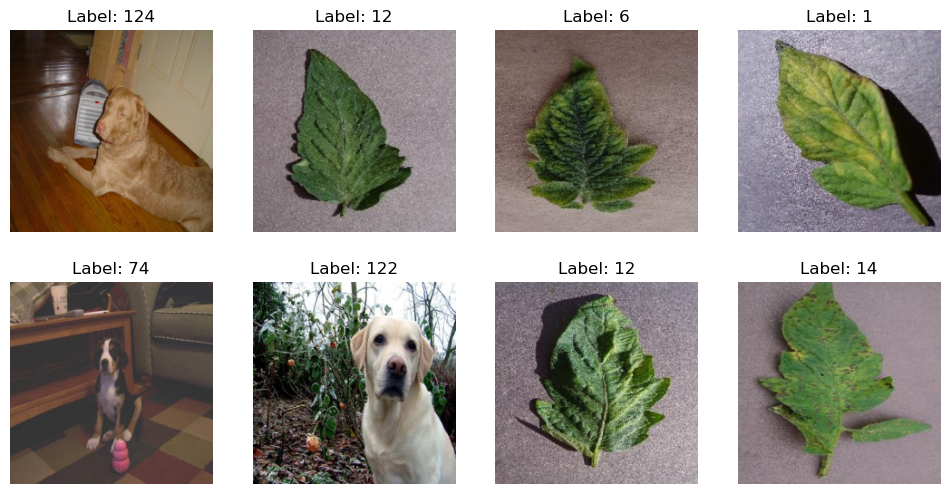

In [15]:
# Function to display a batch of labeled images with labels
def show_labeled_batch(data_loader):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = (img * torch.as_tensor(IMAGENET_DEFAULT_STD)) + torch.as_tensor(IMAGENET_DEFAULT_MEAN)
        plt.imshow(img)
        plt.title(f'Label: {labels[idx].item()}')
        plt.axis('off')
    plt.show()

# Function to display a batch of unlabeled images
def show_unlabeled_batch(data_loader):
    images = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = (img * torch.as_tensor(IMAGENET_DEFAULT_STD)) + torch.as_tensor(IMAGENET_DEFAULT_MEAN)
        plt.imshow(img)
        plt.title("Unlabeled Image")
        plt.axis('off')
    plt.show()

# Display a batch of labeled images
print("Labeled images:")
show_labeled_batch(labeled_train_data)
pass

# # Display a batch of unlabeled images
# print("Unlabeled images:")
# show_unlabeled_batch(unlabeled_loader)


In [16]:
# https://pytorch.org/tutorials/beginner/vt_tutorial.html
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using cache found in /home/argon/.cache/torch/hub/facebookresearch_deit_main
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/argon/.cache/torch/hub/facebookresearch_deit_main/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @regis

In [17]:
# Modify the final layer to match the number of classes
num_classes = len(categories)  # Adjust to the actual number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

In [18]:
# https://www.kaggle.com/code/pdochannel/vision-transformers-in-pytorch-deit/notebook
criterion = LabelSmoothingCrossEntropy()
# criterion = criterion.to(device)
if not "optimizer_type" in training_config or training_config["optimizer_type"] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
elif training_config["optimizer_type"] == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=training_config["optimizer_lr"], weight_decay=training_config["optimizer_wd"])
else:
    raise NotImplementedError()
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)


In [19]:
def freeze_by_list(model, unfrozen):
    # https://stackoverflow.com/questions/62523912/freeze-certain-layers-of-an-existing-model-in-pytorch
    total_unfrozen = 0
    for name, param in model.named_parameters():
        if name in unfrozen:
            total_unfrozen += 1
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

if "unfreeze_layers" in training_config:
    freeze_by_list(model, training_config["unfreeze_layers"])

[(i[0], i[1].requires_grad) for i in model.named_parameters()]

[('cls_token', False),
 ('pos_embed', False),
 ('patch_embed.proj.weight', False),
 ('patch_embed.proj.bias', False),
 ('blocks.0.norm1.weight', False),
 ('blocks.0.norm1.bias', False),
 ('blocks.0.attn.qkv.weight', False),
 ('blocks.0.attn.qkv.bias', False),
 ('blocks.0.attn.proj.weight', False),
 ('blocks.0.attn.proj.bias', False),
 ('blocks.0.norm2.weight', False),
 ('blocks.0.norm2.bias', False),
 ('blocks.0.mlp.fc1.weight', False),
 ('blocks.0.mlp.fc1.bias', False),
 ('blocks.0.mlp.fc2.weight', False),
 ('blocks.0.mlp.fc2.bias', False),
 ('blocks.1.norm1.weight', False),
 ('blocks.1.norm1.bias', False),
 ('blocks.1.attn.qkv.weight', False),
 ('blocks.1.attn.qkv.bias', False),
 ('blocks.1.attn.proj.weight', False),
 ('blocks.1.attn.proj.bias', False),
 ('blocks.1.norm2.weight', False),
 ('blocks.1.norm2.bias', False),
 ('blocks.1.mlp.fc1.weight', False),
 ('blocks.1.mlp.fc1.bias', False),
 ('blocks.1.mlp.fc2.weight', False),
 ('blocks.1.mlp.fc2.bias', False),
 ('blocks.2.norm1.weig

In [20]:
# lr scheduler
if "scheduler_type" in training_config:
    if training_config["scheduler_type"] == "StepLR":
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "ExponentialLR":
        lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, **training_config["scheduler_params"])
    if training_config["scheduler_type"] == "ReduceLROnPlateau":
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **training_config["scheduler_params"])
else:
    lr_scheduler = None
print(lr_scheduler)

In [21]:
model_path = os.path.join(model_prefix, training_config["model_name"])
os.makedirs(model_path, exist_ok=True)

In [22]:
num_epochs = 15  # Adjust as needed

In [23]:
model.to(device)
start_epoch = 0
hist = TrainingHistory()

checkpoint_path = os.path.join(model_path, "checkpoint.pth")
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, lr_scheduler, device=device)
    hist.load(os.path.join(model_path, "history.json"))

In [24]:
# d = model.state_dict()
# possible_keys = list(d.keys())
# print(len(d), len(training_config["unfreeze_layers"]))
# for k in possible_keys:
#     if not k in training_config["unfreeze_layers"]:
#         d.pop(k)
# print(len(d), len(training_config["unfreeze_layers"]))

In [25]:
# missing_keys, unexpected_keys = model.load_state_dict(d, strict=False)
# assert len(unexpected_keys) == 0
# assert len(missing_keys) == len(model.state_dict()) - len(training_config["unfreeze_layers"])

In [26]:
# Save an untrained reference we can use to start each fold without running all the code again
save_checkpoint(os.path.join(model_path, "checkpoint-untrained.pth"), 0, model, optimizer, lr_scheduler, select_layers=training_config.get("unfreeze_layers"))

In [27]:
model.to(device)

if "kfold" in training_config:
    training_num_folds = training_config["kfold"]
else:
    training_num_folds = 1

for i_fold in range(training_num_folds):
    train_idx, val_idx = make_fold(split_group_idx, i_fold)
    print("Fold:", i_fold, "Train:", len(train_idx), "Val:", len(val_idx), "Ratio:", len(val_idx)/(len(val_idx)+len(train_idx)))

    train =  torch.utils.data.Subset(train_dataset, train_idx)
    val = torch.utils.data.Subset(val_dataset, val_idx)

    labeled_train_data = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
    labeled_val_data = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)

    if training_num_folds == 1:
        checkpoint_prefix = "checkpoint"
        history_name = "history.json"
    else:
        checkpoint_prefix = f"checkpoint-fold{i_fold}"
        history_name = f"history-fold{i_fold}.json"

    start_epoch = 0
    hist = TrainingHistory()
    checkpoint_path = os.path.join(model_path, "{checkpoint_prefix}.pth")
    if os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(checkpoint_path, model, optimizer, lr_scheduler, select_layers=training_config.get("unfreeze_layers"), device=device)
        hist.load(os.path.join(model_path, "history.json"))
        print("Resuming from checkpoint at epoch", start_epoch)
    else:
        load_checkpoint(os.path.join(model_path, "checkpoint-untrained.pth"), model, optimizer, lr_scheduler, select_layers=training_config.get("unfreeze_layers"), device=device)
        print("Initializing from checkpoint-untrained.pth")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        model.train()
        for images, labels in tqdm.tqdm(labeled_train_data, desc=f"Train ({i_fold}) ({epoch+1}/{num_epochs})"):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        for images, labels in tqdm.tqdm(labeled_val_data, desc=f"Validation ({i_fold}) ({epoch+1}/{num_epochs})"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
        
        if training_config["scheduler_type"] == "ReduceLROnPlateau":
            lr_scheduler.step(val_loss)
        elif lr_scheduler:
            lr_scheduler.step()
        
        tmp_checkpoint_path = os.path.join(model_path, f"{checkpoint_prefix}-{epoch}.pth")
        save_checkpoint(tmp_checkpoint_path, epoch + 1, model, optimizer, lr_scheduler, select_layers=training_config.get("unfreeze_layers"))
        shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"{checkpoint_prefix}.pth"))
        if hist.is_best():
            shutil.copyfile(tmp_checkpoint_path, os.path.join(model_path, f"{checkpoint_prefix}-best.pth"))
        os.unlink(tmp_checkpoint_path)

        hist.append(train_loss/train_total, val_loss/val_total, train_correct/train_total, val_correct/val_total)
        hist.save(os.path.join(model_path, history_name))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/train_total:.6f}, Val Loss: {val_loss/val_total:.6f}")
        print(f"      Train Accuracy: {100 * train_correct/train_total:.2f}%, Val Accuracy: {100 * val_correct/val_total:.2f}%")
        print(f"      New LR={[g['lr'] for g in optimizer.param_groups]}")


/tmp/ipykernel_252362/4031851096.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Fold: 0 Train: 7826 Val: 2028 Ratio: 0.20580474934036938
Initializing from checkpoint-untrained.pth


Validation (0) (1/15): 100%|██████████| 127/127 [00:03<00:00, 39.00it/s]


Epoch [1/15], Train Loss: 0.108061, Val Loss: 0.065934
      Train Accuracy: 79.94%, Val Accuracy: 91.96%
      New LR=[8e-05]


Validation (0) (2/15): 100%|██████████| 127/127 [00:03<00:00, 39.79it/s]


Epoch [2/15], Train Loss: 0.057384, Val Loss: 0.062689
      Train Accuracy: 97.57%, Val Accuracy: 94.33%
      New LR=[6.400000000000001e-05]


Validation (0) (3/15): 100%|██████████| 127/127 [00:03<00:00, 39.89it/s]


Epoch [3/15], Train Loss: 0.053894, Val Loss: 0.061294
      Train Accuracy: 99.36%, Val Accuracy: 95.51%
      New LR=[5.120000000000001e-05]


Validation (0) (4/15): 100%|██████████| 127/127 [00:03<00:00, 40.04it/s]


Epoch [4/15], Train Loss: 0.052680, Val Loss: 0.061070
      Train Accuracy: 99.81%, Val Accuracy: 95.76%
      New LR=[4.0960000000000014e-05]


Validation (0) (5/15): 100%|██████████| 127/127 [00:03<00:00, 39.76it/s]


Epoch [5/15], Train Loss: 0.052099, Val Loss: 0.061023
      Train Accuracy: 99.94%, Val Accuracy: 95.66%
      New LR=[3.2768000000000016e-05]


Validation (0) (6/15): 100%|██████████| 127/127 [00:03<00:00, 39.48it/s]


Epoch [6/15], Train Loss: 0.051803, Val Loss: 0.060970
      Train Accuracy: 99.96%, Val Accuracy: 95.91%
      New LR=[2.6214400000000015e-05]


Validation (0) (7/15): 100%|██████████| 127/127 [00:03<00:00, 39.85it/s]


Epoch [7/15], Train Loss: 0.051640, Val Loss: 0.061063
      Train Accuracy: 99.95%, Val Accuracy: 96.10%
      New LR=[2.0971520000000012e-05]


Validation (0) (8/15): 100%|██████████| 127/127 [00:03<00:00, 40.14it/s]


Epoch [8/15], Train Loss: 0.051511, Val Loss: 0.061120
      Train Accuracy: 99.97%, Val Accuracy: 95.86%
      New LR=[1.677721600000001e-05]


Validation (0) (9/15): 100%|██████████| 127/127 [00:03<00:00, 39.87it/s]


Epoch [9/15], Train Loss: 0.051439, Val Loss: 0.061196
      Train Accuracy: 99.96%, Val Accuracy: 95.86%
      New LR=[1.3421772800000009e-05]


Validation (0) (10/15): 100%|██████████| 127/127 [00:03<00:00, 39.88it/s]


Epoch [10/15], Train Loss: 0.051375, Val Loss: 0.061229
      Train Accuracy: 99.97%, Val Accuracy: 95.96%
      New LR=[1.0737418240000008e-05]


Validation (0) (11/15): 100%|██████████| 127/127 [00:03<00:00, 39.76it/s]


Epoch [11/15], Train Loss: 0.051321, Val Loss: 0.061233
      Train Accuracy: 99.96%, Val Accuracy: 96.01%
      New LR=[8.589934592000007e-06]


Validation (0) (12/15): 100%|██████████| 127/127 [00:03<00:00, 39.66it/s]


Epoch [12/15], Train Loss: 0.051288, Val Loss: 0.061289
      Train Accuracy: 99.97%, Val Accuracy: 95.91%
      New LR=[6.871947673600007e-06]


Validation (0) (13/15): 100%|██████████| 127/127 [00:03<00:00, 40.01it/s]


Epoch [13/15], Train Loss: 0.051248, Val Loss: 0.061298
      Train Accuracy: 99.95%, Val Accuracy: 96.10%
      New LR=[5.4975581388800055e-06]


Validation (0) (14/15): 100%|██████████| 127/127 [00:03<00:00, 39.69it/s]


Epoch [14/15], Train Loss: 0.051214, Val Loss: 0.061332
      Train Accuracy: 99.99%, Val Accuracy: 96.10%
      New LR=[4.3980465111040045e-06]


Validation (0) (15/15): 100%|██████████| 127/127 [00:03<00:00, 39.81it/s]


Epoch [15/15], Train Loss: 0.051188, Val Loss: 0.061365
      Train Accuracy: 99.99%, Val Accuracy: 95.96%
      New LR=[3.5184372088832037e-06]
Fold: 1 Train: 7853 Val: 2001 Ratio: 0.20306474528110413
Initializing from checkpoint-untrained.pth


Validation (1) (1/15): 100%|██████████| 126/126 [00:03<00:00, 39.07it/s]


Epoch [1/15], Train Loss: 0.108174, Val Loss: 0.066511
      Train Accuracy: 79.68%, Val Accuracy: 93.80%
      New LR=[8e-05]


Validation (1) (2/15): 100%|██████████| 126/126 [00:03<00:00, 40.20it/s]


Epoch [2/15], Train Loss: 0.057223, Val Loss: 0.063089
      Train Accuracy: 98.00%, Val Accuracy: 95.05%
      New LR=[6.400000000000001e-05]


Validation (1) (3/15): 100%|██████████| 126/126 [00:03<00:00, 40.00it/s]


Epoch [3/15], Train Loss: 0.053605, Val Loss: 0.062355
      Train Accuracy: 99.64%, Val Accuracy: 95.25%
      New LR=[5.120000000000001e-05]


Validation (1) (4/15): 100%|██████████| 126/126 [00:03<00:00, 39.80it/s]


Epoch [4/15], Train Loss: 0.052353, Val Loss: 0.062061
      Train Accuracy: 99.95%, Val Accuracy: 95.50%
      New LR=[4.0960000000000014e-05]


Validation (1) (5/15): 100%|██████████| 126/126 [00:03<00:00, 40.10it/s]


Epoch [5/15], Train Loss: 0.051944, Val Loss: 0.061999
      Train Accuracy: 99.96%, Val Accuracy: 95.65%
      New LR=[3.2768000000000016e-05]


Validation (1) (6/15): 100%|██████████| 126/126 [00:03<00:00, 40.20it/s]


Epoch [6/15], Train Loss: 0.051643, Val Loss: 0.062140
      Train Accuracy: 99.99%, Val Accuracy: 95.65%
      New LR=[2.6214400000000015e-05]


Validation (1) (7/15): 100%|██████████| 126/126 [00:03<00:00, 40.18it/s]


Epoch [7/15], Train Loss: 0.051510, Val Loss: 0.062183
      Train Accuracy: 99.97%, Val Accuracy: 95.50%
      New LR=[2.0971520000000012e-05]


Validation (1) (8/15): 100%|██████████| 126/126 [00:03<00:00, 40.00it/s]


Epoch [8/15], Train Loss: 0.051391, Val Loss: 0.062335
      Train Accuracy: 100.00%, Val Accuracy: 95.35%
      New LR=[1.677721600000001e-05]


Validation (1) (9/15): 100%|██████████| 126/126 [00:03<00:00, 40.09it/s]


Epoch [9/15], Train Loss: 0.051311, Val Loss: 0.062351
      Train Accuracy: 100.00%, Val Accuracy: 95.55%
      New LR=[1.3421772800000009e-05]


Validation (1) (10/15): 100%|██████████| 126/126 [00:03<00:00, 40.20it/s]


Epoch [10/15], Train Loss: 0.051249, Val Loss: 0.062490
      Train Accuracy: 100.00%, Val Accuracy: 95.45%
      New LR=[1.0737418240000008e-05]


Validation (1) (11/15): 100%|██████████| 126/126 [00:03<00:00, 40.28it/s]


Epoch [11/15], Train Loss: 0.051202, Val Loss: 0.062494
      Train Accuracy: 100.00%, Val Accuracy: 95.50%
      New LR=[8.589934592000007e-06]


Validation (1) (12/15): 100%|██████████| 126/126 [00:03<00:00, 40.12it/s]


Epoch [12/15], Train Loss: 0.051161, Val Loss: 0.062515
      Train Accuracy: 100.00%, Val Accuracy: 95.45%
      New LR=[6.871947673600007e-06]


Validation (1) (13/15): 100%|██████████| 126/126 [00:03<00:00, 40.15it/s]


Epoch [13/15], Train Loss: 0.051129, Val Loss: 0.062592
      Train Accuracy: 100.00%, Val Accuracy: 95.50%
      New LR=[5.4975581388800055e-06]


Validation (1) (14/15): 100%|██████████| 126/126 [00:03<00:00, 39.50it/s]


Epoch [14/15], Train Loss: 0.051103, Val Loss: 0.062564
      Train Accuracy: 100.00%, Val Accuracy: 95.55%
      New LR=[4.3980465111040045e-06]


Validation (1) (15/15): 100%|██████████| 126/126 [00:03<00:00, 39.70it/s]


Epoch [15/15], Train Loss: 0.051078, Val Loss: 0.062703
      Train Accuracy: 100.00%, Val Accuracy: 95.70%
      New LR=[3.5184372088832037e-06]
Fold: 2 Train: 7887 Val: 1967 Ratio: 0.19961436979906638
Initializing from checkpoint-untrained.pth


Validation (2) (1/15): 100%|██████████| 123/123 [00:03<00:00, 38.57it/s]


Epoch [1/15], Train Loss: 0.108333, Val Loss: 0.065633
      Train Accuracy: 79.37%, Val Accuracy: 92.73%
      New LR=[8e-05]


Validation (2) (2/15): 100%|██████████| 123/123 [00:03<00:00, 39.79it/s]


Epoch [2/15], Train Loss: 0.057529, Val Loss: 0.061582
      Train Accuracy: 97.59%, Val Accuracy: 95.12%
      New LR=[6.400000000000001e-05]


Validation (2) (3/15): 100%|██████████| 123/123 [00:03<00:00, 39.87it/s]


Epoch [3/15], Train Loss: 0.054013, Val Loss: 0.060528
      Train Accuracy: 99.25%, Val Accuracy: 95.37%
      New LR=[5.120000000000001e-05]


Validation (2) (4/15): 100%|██████████| 123/123 [00:03<00:00, 39.72it/s]


Epoch [4/15], Train Loss: 0.052568, Val Loss: 0.060543
      Train Accuracy: 99.85%, Val Accuracy: 95.63%
      New LR=[4.0960000000000014e-05]


Validation (2) (5/15): 100%|██████████| 123/123 [00:03<00:00, 40.26it/s]


Epoch [5/15], Train Loss: 0.052016, Val Loss: 0.060241
      Train Accuracy: 99.90%, Val Accuracy: 95.73%
      New LR=[3.2768000000000016e-05]


Validation (2) (6/15): 100%|██████████| 123/123 [00:03<00:00, 40.00it/s]


Epoch [6/15], Train Loss: 0.051745, Val Loss: 0.060492
      Train Accuracy: 99.95%, Val Accuracy: 95.68%
      New LR=[2.6214400000000015e-05]


Validation (2) (7/15): 100%|██████████| 123/123 [00:03<00:00, 39.45it/s]


Epoch [7/15], Train Loss: 0.051597, Val Loss: 0.060511
      Train Accuracy: 99.92%, Val Accuracy: 95.78%
      New LR=[2.0971520000000012e-05]


Validation (2) (8/15): 100%|██████████| 123/123 [00:03<00:00, 39.71it/s]


Epoch [8/15], Train Loss: 0.051459, Val Loss: 0.060417
      Train Accuracy: 99.96%, Val Accuracy: 95.73%
      New LR=[1.677721600000001e-05]


Validation (2) (9/15): 100%|██████████| 123/123 [00:03<00:00, 39.79it/s]


Epoch [9/15], Train Loss: 0.051377, Val Loss: 0.060342
      Train Accuracy: 99.95%, Val Accuracy: 95.93%
      New LR=[1.3421772800000009e-05]


Validation (2) (10/15): 100%|██████████| 123/123 [00:03<00:00, 39.91it/s]


Epoch [10/15], Train Loss: 0.051321, Val Loss: 0.060459
      Train Accuracy: 99.94%, Val Accuracy: 95.88%
      New LR=[1.0737418240000008e-05]


Validation (2) (11/15): 100%|██████████| 123/123 [00:03<00:00, 39.65it/s]


Epoch [11/15], Train Loss: 0.051256, Val Loss: 0.060654
      Train Accuracy: 99.96%, Val Accuracy: 95.98%
      New LR=[8.589934592000007e-06]


Validation (2) (12/15): 100%|██████████| 123/123 [00:03<00:00, 39.71it/s]


Epoch [12/15], Train Loss: 0.051215, Val Loss: 0.060573
      Train Accuracy: 99.95%, Val Accuracy: 95.88%
      New LR=[6.871947673600007e-06]


Validation (2) (13/15): 100%|██████████| 123/123 [00:03<00:00, 39.58it/s]


Epoch [13/15], Train Loss: 0.051184, Val Loss: 0.060566
      Train Accuracy: 99.94%, Val Accuracy: 95.88%
      New LR=[5.4975581388800055e-06]


Validation (2) (14/15): 100%|██████████| 123/123 [00:03<00:00, 39.72it/s]


Epoch [14/15], Train Loss: 0.051158, Val Loss: 0.060588
      Train Accuracy: 99.92%, Val Accuracy: 95.88%
      New LR=[4.3980465111040045e-06]


Validation (2) (15/15): 100%|██████████| 123/123 [00:03<00:00, 39.59it/s]


Epoch [15/15], Train Loss: 0.051124, Val Loss: 0.060638
      Train Accuracy: 99.94%, Val Accuracy: 95.98%
      New LR=[3.5184372088832037e-06]
Fold: 3 Train: 7913 Val: 1941 Ratio: 0.19697584737162574
Initializing from checkpoint-untrained.pth


Validation (3) (1/15): 100%|██████████| 122/122 [00:03<00:00, 38.46it/s]


Epoch [1/15], Train Loss: 0.108334, Val Loss: 0.064329
      Train Accuracy: 79.86%, Val Accuracy: 93.97%
      New LR=[8e-05]


Validation (3) (2/15): 100%|██████████| 122/122 [00:03<00:00, 39.95it/s]


Epoch [2/15], Train Loss: 0.057364, Val Loss: 0.061666
      Train Accuracy: 97.66%, Val Accuracy: 95.78%
      New LR=[6.400000000000001e-05]


Validation (3) (3/15): 100%|██████████| 122/122 [00:03<00:00, 40.10it/s]


Epoch [3/15], Train Loss: 0.053788, Val Loss: 0.061365
      Train Accuracy: 99.48%, Val Accuracy: 95.52%
      New LR=[5.120000000000001e-05]


Validation (3) (4/15): 100%|██████████| 122/122 [00:03<00:00, 40.02it/s]


Epoch [4/15], Train Loss: 0.052570, Val Loss: 0.060816
      Train Accuracy: 99.80%, Val Accuracy: 95.88%
      New LR=[4.0960000000000014e-05]


Validation (3) (5/15): 100%|██████████| 122/122 [00:03<00:00, 39.70it/s]


Epoch [5/15], Train Loss: 0.052069, Val Loss: 0.060804
      Train Accuracy: 99.90%, Val Accuracy: 95.98%
      New LR=[3.2768000000000016e-05]


Validation (3) (6/15): 100%|██████████| 122/122 [00:03<00:00, 40.21it/s]


Epoch [6/15], Train Loss: 0.051786, Val Loss: 0.060880
      Train Accuracy: 99.92%, Val Accuracy: 95.98%
      New LR=[2.6214400000000015e-05]


Validation (3) (7/15): 100%|██████████| 122/122 [00:03<00:00, 40.03it/s]


Epoch [7/15], Train Loss: 0.051621, Val Loss: 0.060963
      Train Accuracy: 99.92%, Val Accuracy: 95.98%
      New LR=[2.0971520000000012e-05]


Validation (3) (8/15): 100%|██████████| 122/122 [00:03<00:00, 39.64it/s]


Epoch [8/15], Train Loss: 0.051491, Val Loss: 0.061124
      Train Accuracy: 99.95%, Val Accuracy: 96.03%
      New LR=[1.677721600000001e-05]


Validation (3) (9/15): 100%|██████████| 122/122 [00:03<00:00, 39.94it/s]


Epoch [9/15], Train Loss: 0.051413, Val Loss: 0.061150
      Train Accuracy: 99.95%, Val Accuracy: 96.08%
      New LR=[1.3421772800000009e-05]


Validation (3) (10/15): 100%|██████████| 122/122 [00:03<00:00, 39.99it/s]


Epoch [10/15], Train Loss: 0.051346, Val Loss: 0.060984
      Train Accuracy: 99.95%, Val Accuracy: 96.19%
      New LR=[1.0737418240000008e-05]


Validation (3) (11/15): 100%|██████████| 122/122 [00:03<00:00, 39.81it/s]


Epoch [11/15], Train Loss: 0.051293, Val Loss: 0.061178
      Train Accuracy: 99.96%, Val Accuracy: 96.14%
      New LR=[8.589934592000007e-06]


Validation (3) (12/15): 100%|██████████| 122/122 [00:03<00:00, 40.00it/s]


Epoch [12/15], Train Loss: 0.051249, Val Loss: 0.061142
      Train Accuracy: 99.95%, Val Accuracy: 96.19%
      New LR=[6.871947673600007e-06]


Validation (3) (13/15): 100%|██████████| 122/122 [00:03<00:00, 39.77it/s]


Epoch [13/15], Train Loss: 0.051221, Val Loss: 0.061255
      Train Accuracy: 99.95%, Val Accuracy: 96.08%
      New LR=[5.4975581388800055e-06]


Validation (3) (14/15): 100%|██████████| 122/122 [00:02<00:00, 41.89it/s]


Epoch [14/15], Train Loss: 0.051191, Val Loss: 0.061197
      Train Accuracy: 99.96%, Val Accuracy: 96.24%
      New LR=[4.3980465111040045e-06]


Validation (3) (15/15): 100%|██████████| 122/122 [00:02<00:00, 41.68it/s]


Epoch [15/15], Train Loss: 0.051159, Val Loss: 0.061258
      Train Accuracy: 99.96%, Val Accuracy: 96.19%
      New LR=[3.5184372088832037e-06]
Fold: 4 Train: 7937 Val: 1917 Ratio: 0.1945402882078344
Initializing from checkpoint-untrained.pth


Validation (4) (1/15): 100%|██████████| 120/120 [00:02<00:00, 40.20it/s]


Epoch [1/15], Train Loss: 0.107850, Val Loss: 0.064619
      Train Accuracy: 79.65%, Val Accuracy: 93.69%
      New LR=[8e-05]


Validation (4) (2/15): 100%|██████████| 120/120 [00:02<00:00, 41.67it/s]


Epoch [2/15], Train Loss: 0.057405, Val Loss: 0.061480
      Train Accuracy: 97.76%, Val Accuracy: 95.31%
      New LR=[6.400000000000001e-05]


Validation (4) (3/15): 100%|██████████| 120/120 [00:02<00:00, 41.61it/s]


Epoch [3/15], Train Loss: 0.053868, Val Loss: 0.061147
      Train Accuracy: 99.48%, Val Accuracy: 95.20%
      New LR=[5.120000000000001e-05]


Validation (4) (4/15): 100%|██████████| 120/120 [00:02<00:00, 41.81it/s]


Epoch [4/15], Train Loss: 0.052640, Val Loss: 0.060797
      Train Accuracy: 99.85%, Val Accuracy: 95.51%
      New LR=[4.0960000000000014e-05]


Validation (4) (5/15): 100%|██████████| 120/120 [00:02<00:00, 41.70it/s]


Epoch [5/15], Train Loss: 0.052072, Val Loss: 0.060786
      Train Accuracy: 99.94%, Val Accuracy: 95.93%
      New LR=[3.2768000000000016e-05]


Validation (4) (6/15): 100%|██████████| 120/120 [00:02<00:00, 41.71it/s]


Epoch [6/15], Train Loss: 0.051826, Val Loss: 0.061023
      Train Accuracy: 99.95%, Val Accuracy: 95.62%
      New LR=[2.6214400000000015e-05]


Validation (4) (7/15): 100%|██████████| 120/120 [00:02<00:00, 41.52it/s]


Epoch [7/15], Train Loss: 0.051653, Val Loss: 0.060948
      Train Accuracy: 99.95%, Val Accuracy: 95.77%
      New LR=[2.0971520000000012e-05]


Validation (4) (8/15): 100%|██████████| 120/120 [00:02<00:00, 41.75it/s]


Epoch [8/15], Train Loss: 0.051534, Val Loss: 0.061020
      Train Accuracy: 99.97%, Val Accuracy: 95.83%
      New LR=[1.677721600000001e-05]


Validation (4) (9/15): 100%|██████████| 120/120 [00:02<00:00, 41.48it/s]


Epoch [9/15], Train Loss: 0.051448, Val Loss: 0.061080
      Train Accuracy: 99.96%, Val Accuracy: 95.67%
      New LR=[1.3421772800000009e-05]


Validation (4) (10/15): 100%|██████████| 120/120 [00:02<00:00, 41.63it/s]


Epoch [10/15], Train Loss: 0.051388, Val Loss: 0.061149
      Train Accuracy: 99.95%, Val Accuracy: 95.83%
      New LR=[1.0737418240000008e-05]


Validation (4) (11/15): 100%|██████████| 120/120 [00:02<00:00, 41.65it/s]


Epoch [11/15], Train Loss: 0.051333, Val Loss: 0.061128
      Train Accuracy: 99.96%, Val Accuracy: 95.72%
      New LR=[8.589934592000007e-06]


Validation (4) (12/15): 100%|██████████| 120/120 [00:02<00:00, 41.54it/s]


Epoch [12/15], Train Loss: 0.051288, Val Loss: 0.061200
      Train Accuracy: 99.97%, Val Accuracy: 95.83%
      New LR=[6.871947673600007e-06]


Validation (4) (13/15): 100%|██████████| 120/120 [00:02<00:00, 41.55it/s]


Epoch [13/15], Train Loss: 0.051252, Val Loss: 0.061248
      Train Accuracy: 99.96%, Val Accuracy: 95.72%
      New LR=[5.4975581388800055e-06]


Validation (4) (14/15): 100%|██████████| 120/120 [00:02<00:00, 41.54it/s]


Epoch [14/15], Train Loss: 0.051230, Val Loss: 0.061242
      Train Accuracy: 99.95%, Val Accuracy: 95.62%
      New LR=[4.3980465111040045e-06]


Validation (4) (15/15): 100%|██████████| 120/120 [00:02<00:00, 41.60it/s]


Epoch [15/15], Train Loss: 0.051204, Val Loss: 0.061226
      Train Accuracy: 99.96%, Val Accuracy: 95.83%
      New LR=[3.5184372088832037e-06]


Text(0.5, 0, 'Epoch')

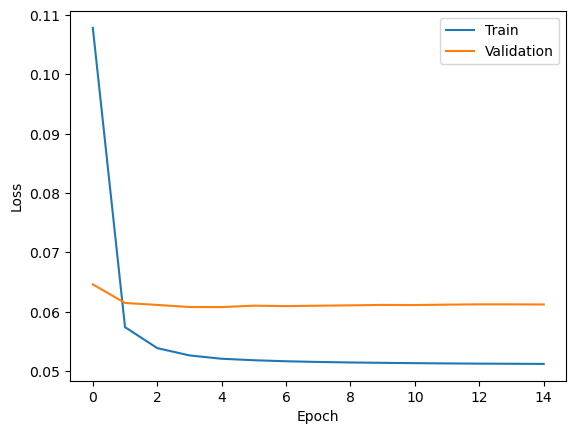

In [28]:
# Plot Loss
plt.plot(range(len(hist.train_loss)), hist.train_loss, label="Train")
plt.plot(range(len(hist.val_loss)), hist.val_loss, label="Validation")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

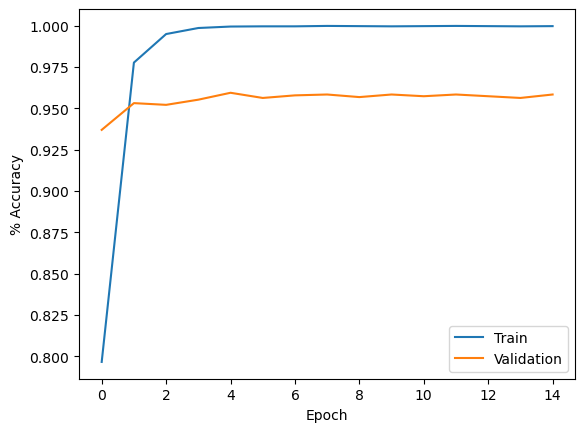

In [29]:
# Plot Accuracy
plt.plot(range(len(hist.train_acc)), hist.train_acc, label="Train")
plt.plot(range(len(hist.val_acc)), hist.val_acc, label="Validation")
plt.legend()
plt.ylabel("% Accuracy")
plt.xlabel("Epoch")

In [30]:
raise "STOP"

TypeError: exceptions must derive from BaseException

In [31]:
test_dataset = ImageDataset(root_dir=os.path.join(data_prefix,'test'), return_filenames=True, transform=transform)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True)

In [32]:
import csv

def create_csv_with_number(base_name, data):
    """Creates a CSV file with a unique number in the filename if the file already exists."""

    file_number = 1
    file_name = f"{base_name}.csv"

    while os.path.exists(file_name):
        file_name = f"{base_name}_{file_number}.csv"
        file_number += 1

    # Save to CSV
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["image", "id"])  # Write header
        writer.writerows(data)  # Write predictions

    print(f"File '{file_name}' created and results saved successfully.")

In [33]:
# hist = None
# best_checkpoint_path = os.path.join(model_path, "checkpoint-best.pth")
# best_epoch = load_checkpoint(best_checkpoint_path, model, optimizer, lr_scheduler, select_layers=training_config.get("unfreeze_layers"), device=device)
# print(best_checkpoint_path)
# print("Best epoch:", best_epoch)

# model.to(device)
# model.eval()
# results = []

# with torch.no_grad():
#     for images, filenames in tqdm.tqdm(test_data, desc="Testing"):
#         images = images.to(device)
#         outputs = model(images)
#         _, predicted = outputs.max(1)  # Get the predicted class IDs

#         # Store filename and predicted label
#         results.extend(zip(filenames, predicted.cpu().numpy()))

# create_csv_with_number("test_submission", results)

In [34]:
import glob

In [35]:
all_results = []
for best_checkpoint_path in sorted(glob.glob(os.path.join(model_path, "checkpoint-*-best.pth"))):
    best_epoch = load_checkpoint(best_checkpoint_path, model, optimizer, lr_scheduler, select_layers=training_config.get("unfreeze_layers"), device=device)
    print(best_checkpoint_path)
    print("Best epoch:", best_epoch)

    model.eval()
    chk_results = []

    with torch.no_grad():
        for images, filenames in tqdm.tqdm(test_data, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            #FIXME: Should be argmax
            _, predicted = outputs.max(1)  # Get the predicted class IDs

            # Store filename and predicted label
            chk_results.extend(zip(filenames, predicted.cpu().numpy().tolist()))
    all_results.append(dict(chk_results))

/tmp/ipykernel_252362/4031851096.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


/home/argon/Stuff/CSE244A_project/models/michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4/checkpoint-fold0-best.pth
Best epoch: 7


Testing: 100%|██████████| 514/514 [00:12<00:00, 40.77it/s]


/home/argon/Stuff/CSE244A_project/models/michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4/checkpoint-fold1-best.pth
Best epoch: 6


Testing: 100%|██████████| 514/514 [00:12<00:00, 41.35it/s]


/home/argon/Stuff/CSE244A_project/models/michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4/checkpoint-fold2-best.pth
Best epoch: 6


Testing: 100%|██████████| 514/514 [00:12<00:00, 41.19it/s]


/home/argon/Stuff/CSE244A_project/models/michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4/checkpoint-fold3-best.pth
Best epoch: 6


Testing: 100%|██████████| 514/514 [00:12<00:00, 41.25it/s]


/home/argon/Stuff/CSE244A_project/models/michelle_diet_imagenetmean_augmentD__freeze10__kfold5__explr_1en4_0.8__AdamW_wdecay_1en4/checkpoint-fold4-best.pth
Best epoch: 6


Testing: 100%|██████████| 514/514 [00:12<00:00, 41.25it/s]


In [36]:
#TODO: This is a silly way to merge things, should just use a defaultdict or something...
import numpy as np

combined_results = {}
winning_votes = np.zeros(len(all_results)+1)
for k in sorted(all_results[0].keys()):
    votes = []
    for d in all_results:
        votes.append(d[k])
    vote_counts = np.unique(votes, return_counts=True)
    winner = np.argmax(vote_counts[1])
    combined_results[k] = int(vote_counts[0][winner])
    winning_votes[vote_counts[1][winner]] += 1
print("How many models voted for the winners:", winning_votes)

How many models voted for the winners: [   0.    0.   14.  150.  214. 7835.]


In [38]:
create_csv_with_number("test_submission_folded", [[k, combined_results[k]] for k in sorted(combined_results.keys())])

File 'test_submission_folded.csv' created and results saved successfully.
